In [1]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib import patheffects
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter
import xarray as xr

In [2]:
# Plotting Max and Min data points
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    
    outline_effect = [patheffects.withStroke(linewidth=2.5, foreground='black')]

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == np.array(data))
    
    lon, lat = np.meshgrid(lons, lats)

    for i in range(len(mxy)):
        A = ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=24,
                clip_on=True, clip_box=ax.bbox, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        A.set_path_effects(outline_effect)
        
        a = np.array(data[mxy[i], mxx[i]])
        a_trunc = np.trunc(a)
        
        B = ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
                '\n' + str(a_trunc),
                color=color, size=12, clip_on=True, clip_box=ax.bbox, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
        B.set_path_effects(outline_effect)

In [3]:
# Open ERA5 dataset; change name accordingly to yours
ds = xr.open_dataset('EU_Pressure Levels.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 101, level: 20, time: 72)
Coordinates:
  * longitude  (longitude) float32 105.0 105.2 105.5 105.8 ... 139.5 139.8 140.0
  * latitude   (latitude) float32 25.0 24.75 24.5 24.25 ... 0.75 0.5 0.25 0.0
  * level      (level) int32 1 100 150 200 250 300 ... 750 800 850 900 950 1000
  * time       (time) datetime64[ns] 2016-08-13 ... 2016-08-15T23:00:00
Data variables:
    d          (time, level, latitude, longitude) float32 ...
    z          (time, level, latitude, longitude) float32 ...
    pv         (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
    vo         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-05 07:44:20 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [4]:
# Grab lat/lon values (NAM will be 2D)
lats = ds.latitude
lons = ds.longitude

# Select and grab data
geop = ds['z'] 
geop_w_units = geop * units('m ** 2 / s ** 2')
z = mpcalc.geopotential_to_height(geop_w_units)
uwnd = ds['u']
vwnd = ds['v']
temp = ds['t']

# Select and grab 850-hPa geopotential heights, boundary-layer temps,
# and wind components, smooth with gaussian_filter
temp_850 = gaussian_filter(temp.sel(level=850).data[30], sigma=3.0) * units.kelvin
hght_850 = gaussian_filter(z.sel(level=850).data[30], sigma=3.0) * units('m')
hght_850dm = hght_850.to(units.decameter)

uwnd_850 = gaussian_filter(uwnd.sel(level=850).data[30], sigma=3.0) * units('m/s')
vwnd_850 = gaussian_filter(vwnd.sel(level=850).data[30], sigma=3.0) * units('m/s')

# Temperature to degree Celcius
tempc_850 = temp_850.to('degC')

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds.time.data[30].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

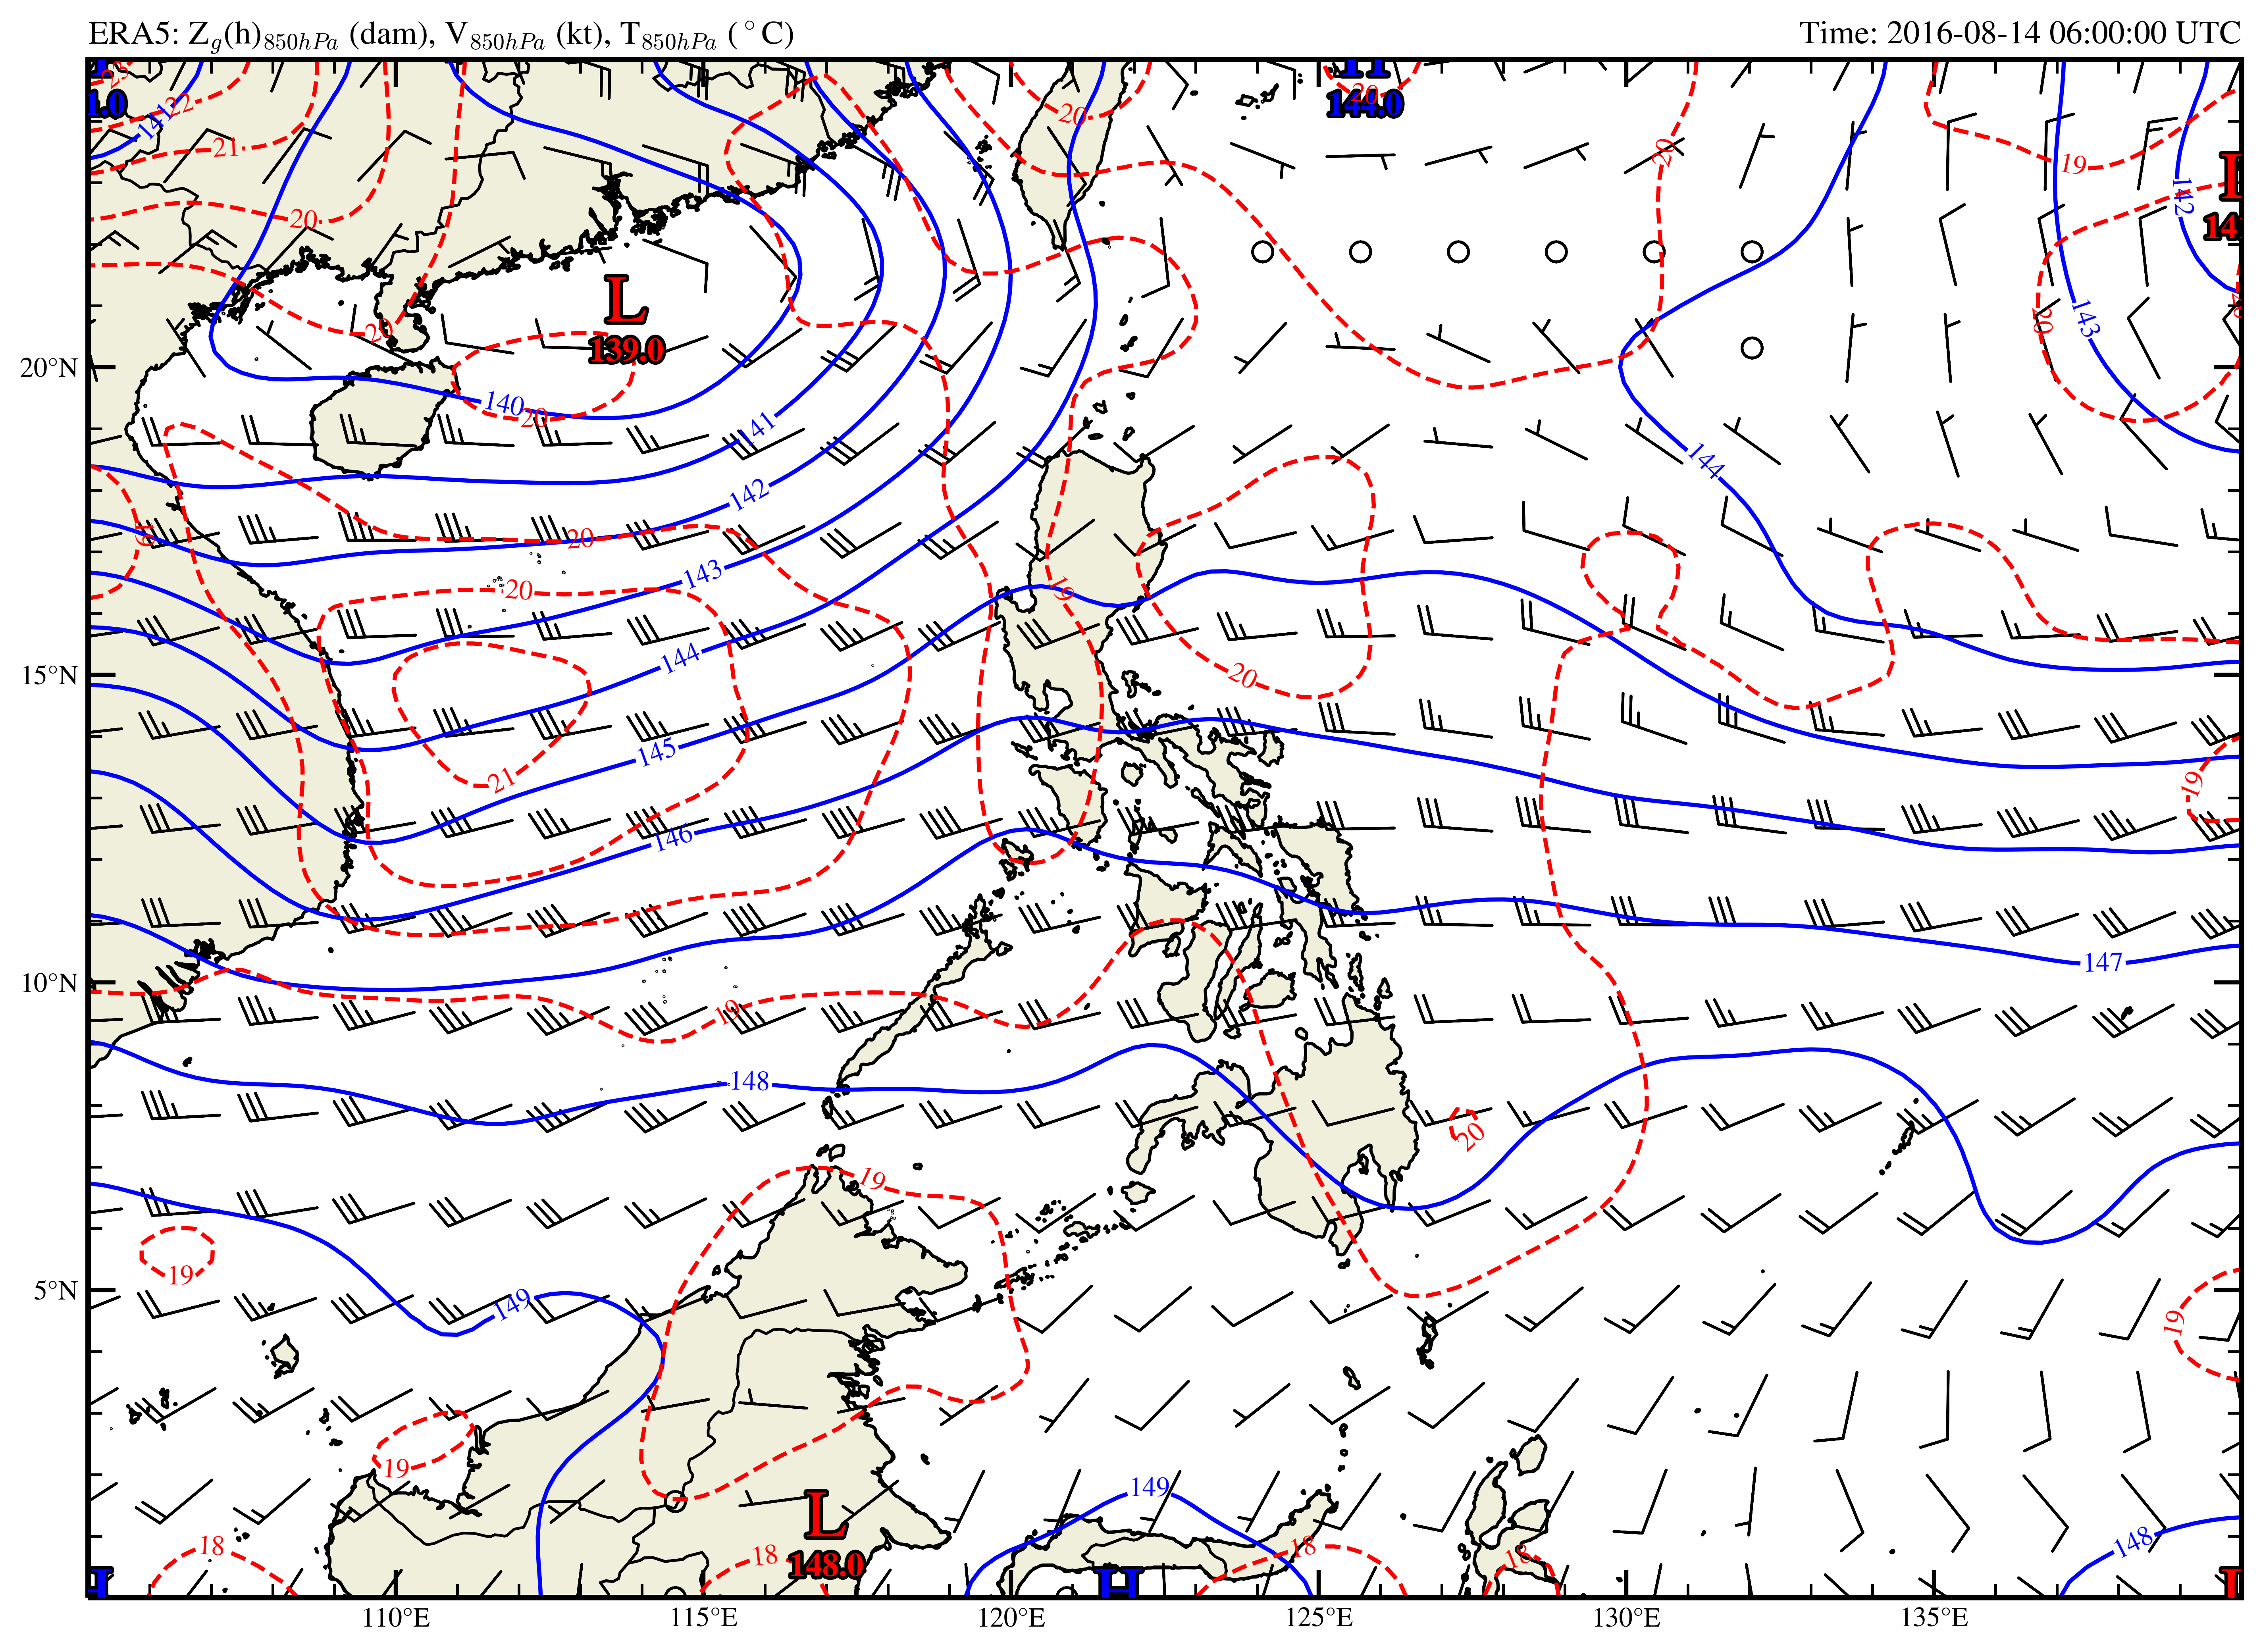

In [6]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([105, 140, 0, 25], ccrs.PlateCarree())

# Add geopolitical boundaries and earth feature for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.15)
ax.add_feature(cfeature.STATES.with_scale('50m'))
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k',
                                        facecolor=cfeature.COLORS['land'], zorder=1)
ax.add_feature(land_10m)

# Plot 850-hPa Geopotential Heights in dam
clevs_850_hght = np.arange(140, 151, 1)
cs = ax.contour(lons, lats, hght_850dm, clevs_850_hght, colors='blue',
                transform=datacrs)
ax.clabel(cs, fmt='%d')

# Plot 850-hPa wind barbs in knots, regrid to reduce number of barbs
ax.barbs(lons, lats, uwnd_850.to('kt').m, vwnd_850.to('kt').m, pivot='middle',
         color='black', regrid_shape=17, transform=datacrs)

# Plot 850-hPa/Boundary-layer Temperature
csf = ax.contour(lons, lats, tempc_850, colors='red',
                 linestyles='dashed', transform=datacrs)
ax.clabel(csf, fmt='%d')

# Plot Highs and Lows (Min/Max) values of Geopotential Height
plot_maxmin_points(lons, lats, hght_850dm, 'max', 40, symbol='H', color='b', transform=datacrs)
plot_maxmin_points(lons, lats, hght_850dm, 'min', 20, symbol='L', color='r', transform=datacrs)

# Make some nice titles for the plot (one right, one left)
plt.title('ERA5: Z$_{g}$(h)$_{850hPa}$ (dam), V$_{850hPa}$ (kt), T$_{850hPa}$ ($^\circ$C)', loc='left')
plt.title('Time: {} UTC'.format(vtime), loc='right')

# Set X and Y-ticks for Latitude and Longitude Coordinates
ax.set_yticks(lats, 5, crs=ccrs.PlateCarree())
ax.set_xticks(lons, 5, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
long_formatter = cticker.LongitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.xaxis.set_major_formatter(long_formatter)
ax.set_xticks(ax.get_xticks()[1:7]) #Hide end points of longitude tickmarks
ax.set_yticks(ax.get_yticks()[1:5]) #Hide end points of latitude tickmarks
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=1.5, top=True, right=True, direction='in')
ax.tick_params(which='minor', length=5, width=1, top=True, right=True, direction='in')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.savefig('GPM, Winds, Temps.jpg', bbox_inches="tight")
plt.show()